# Precipitation Frequency Table

__Description__: Auto-retrieve [NOAA Atlas 14](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_gis.html) precipitation statistics from [FTP](ftp://hdsc.nws.noaa.gov/pub/hdsc/data/) and calcualte the area-averaged precipitation frequency table for the area of interest (AOI). Also calculates the 24-hour rainfall distribution from a set of rainfall data values for 5-minute through 24-hour durations  (see NRCS Engineering Handbook Part 630 https://directives.sc.egov.usda.gov/OpenNonWebContent.aspx?content=43924.wba

__Input__: A vector polygon of the AOI and the durations of interest.

__Output__: A spreadsheet with sheets for each duration and a sheet with the NOAA Atlas 14 volume and region numbers. For each duration, the sheet contains a table with area-averaged precipitation and confidence limits. A spreadsheet with sheets for each recurrence interval that includes the NRCS nested hyetograph for the 24 hour storm.

---

## Load Libraries, Parameters, and Data:

### Libraries:

In [1]:
import sys
sys.path.append('../../core')
from hydromet import*
from hydromet_stratified import precip_hyetograph_nrcs
from hydromet_stratified import precip_hyetograph_12h3h

### Parameters: 

#### Papermill (site specific):

In [2]:

## Filenames and fields:
Project_Area = 'JoCo'          # Project area name
Pluvial_Model = 'P01'                # Pluvial model name
BCN = 'TurkeyCreek'               # Domain/boundary condition name 071200040505 Kansas 102500170609 Nevada '160600140303'
polygon = 'Turkey_Creek.shp'           # Shapefile name
filter_field = 'Name'          #HUC12 Attribute with in the vector polygon used for data selection
select_data = 'TurkeyCreek'                    # Value within the filter_field used for data selection


## Paths:
root_dir = pl.Path(os.getcwd())
datarepository_dir = root_dir.parent.parent/'DataRepository'
polygon_dir = root_dir/'Inputs'/polygon
outputs_dir = root_dir/'Outputs'


brute_force_projection = None

##### Convert all paths to objects:

In [3]:
datarepository_dir = pl.Path(datarepository_dir)
polygon_dir = pl.Path(polygon_dir)
outputs_dir = pl.Path(outputs_dir)

#### Global (project specific):

In [4]:
noaa_data_crs = 4326 #Based on newer version of GeoPandas

durations = ['05m', '10m', '15m', '30m', '60m', '02h', '03h', '06h', '12h', '24h'] 
dur_names = ['5min', '10min', '15min', '30min', '60min', '2hr', '3hr', '6hr', '12hr', '24hr'] 

vol_code_filename = 'NOAA_Atlas_Volume_Codes.json'
Temporal_area_filename = 'NOAA_Temporal_Areas_US.geojson'

verbose = True

## Read Vector Polygon:

### Load as a geodataframe:

In [5]:
gdf = gpd.read_file(polygon_dir)

check_attributes(gdf)

gdf.head(1)

,FID_1,Name,Length,Area,geometry
0,0,TurkeyCreek,142843.007589,6.747305e+08,"POLYGON ((2245859.605 244239.413, 2245841.056 ..."


### Determine projection:
- If a projection cannot be determined automatically, search for the projection using the EPSG number on the following website: https://www.spatialreference.org/, select 'Proj4', and copy and paste the string above, setting it equal to brute_force_projection. Rerun the cell with the brute_force_projection string and the cell below.

In [6]:
print('Original Coordinate Reference System:', gdf.crs)

with fiona.collection(polygon_dir, 'r') as layer:
    try:
        vector_crs_prj = Proj(layer.crs).srs
        if 'epsg' in vector_crs_prj: 
            raise KeyboardInterrupt
        else: 
            print('Vector Layer crs = {}'.format(vector_crs_prj))
        
    except:
        assert brute_force_projection!= None, 'Need to specify projection'
        vector_crs_prj = brute_force_projection
        print('Error: Setting projection as {}'.format(brute_force_projection))

Original Coordinate Reference System: EPSG:3419
Vector Layer crs = +proj=lcc +lat_0=38.3333333333333 +lon_0=-98 +lat_1=39.7833333333333 +lat_2=38.7166666666667 +x_0=399999.99998984 +y_0=0 +datum=NAD83 +units=us-ft +no_defs


### Extract the area of interest, reproject, and plot:

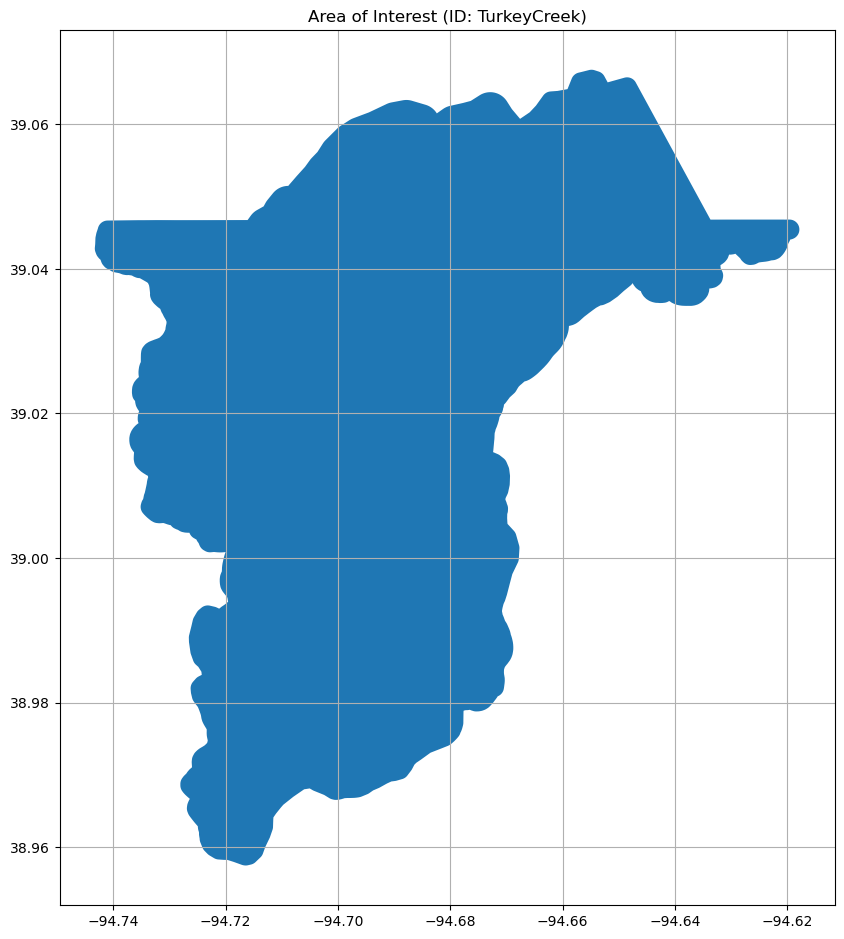

In [7]:
gdf1 = gdf.loc[gdf[filter_field] == select_data].copy()

gdf1.crs = vector_crs_prj
    
geo_df = gdf1.to_crs(epsg = noaa_data_crs)

plot_area_of_interest(geo_df, select_data, filter_field)

## Identify the NOAA Atlas 14 Volume Code:

### Determine the volume and region numbers:

Volume           8
Region           3
Percent_area     100.0


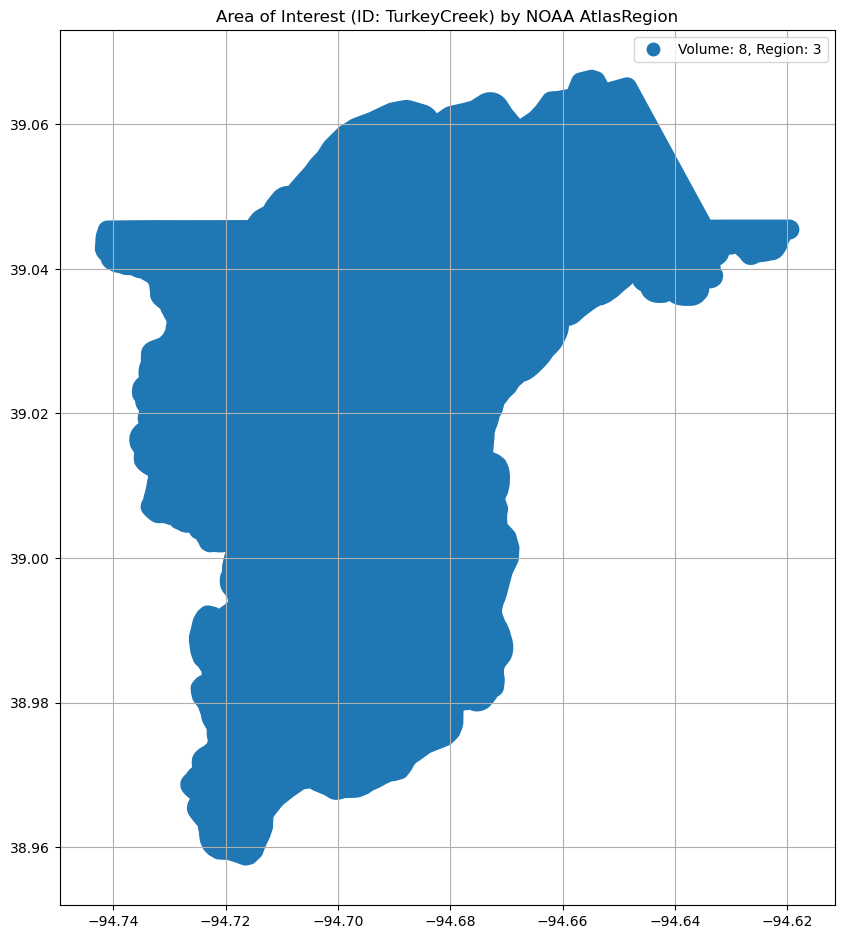

In [8]:
volume_dict, intersection_gdf = intersect_temporal_areas(geo_df, datarepository_dir, Temporal_area_filename, alldata=True)

plot_aoi_noaa_intersection(intersection_gdf, select_data)

volume = volume_dict['Volume']
#volume = '9' # Manually specify the volume if the input shapes do not overlap below

### Load Atlas 14 volume code from json:

In [9]:
vol_code = get_volume_code(datarepository_dir, vol_code_filename, volume)

NOAA Atlas 14 Volume Code: mw


## Retrieve the Precipitation Frequency Data:

### Get list of zip files:

In [10]:
noaa_url = 'https://hdsc.nws.noaa.gov/pub/hdsc/data/{}/'.format(vol_code)

req = urllib.request.Request(noaa_url)
data = urllib.request.urlopen(req).read().decode().split()

copy_zips = []
for duration in durations:
    zips = [d for d in data if ('.zip' in d) and ('{}'.format(duration) in d) and ('ams' not in d)]
    copy_zips.append(zips)
    if verbose: 
        print('{} files found for {}'.format(len(zips), duration))

all_zips_list = list(np.array(copy_zips).flat)

for i, zip_name in enumerate(all_zips_list):
    all_zips_list[i]= zip_name.split("\"", 1)[1].split("\"", 1)[0]

30 files found for 05m
30 files found for 10m
30 files found for 15m
30 files found for 30m
30 files found for 60m
30 files found for 02h
30 files found for 03h
30 files found for 06h
30 files found for 12h
30 files found for 24h


### Iterate through zip files and build a table:

In [11]:
df = build_precip_table(geo_df, all_zips_list, noaa_url, vol_code, 10, verbose) #The integer is the number of times to attempt getting the file from ftp

0 mw1yr05ma.zip
1 mw1yr05mal.zip
2 mw1yr05mau.zip
3 mw2yr05ma.zip
4 mw2yr05mal.zip
5 mw2yr05mau.zip
6 mw5yr05ma.zip
7 mw5yr05mal.zip
8 mw5yr05mau.zip
9 mw10yr05ma.zip
10 mw10yr05mal.zip
11 mw10yr05mau.zip
12 mw25yr05ma.zip
13 mw25yr05mal.zip
14 mw25yr05mau.zip
15 mw50yr05ma.zip
16 mw50yr05mal.zip
17 mw50yr05mau.zip
18 mw100yr05ma.zip
19 mw100yr05mal.zip
20 mw100yr05mau.zip
21 mw200yr05ma.zip
22 mw200yr05mal.zip
23 mw200yr05mau.zip
24 mw500yr05ma.zip
25 mw500yr05mal.zip
26 mw500yr05mau.zip
27 mw1000yr05ma.zip
28 mw1000yr05mal.zip
29 mw1000yr05mau.zip
30 mw1yr10ma.zip
31 mw1yr10mal.zip
32 mw1yr10mau.zip
33 mw2yr10ma.zip
34 mw2yr10mal.zip
35 mw2yr10mau.zip
36 mw5yr10ma.zip
37 mw5yr10mal.zip
38 mw5yr10mau.zip
39 mw10yr10ma.zip
40 mw10yr10mal.zip
41 mw10yr10mau.zip
42 mw25yr10ma.zip
43 mw25yr10mal.zip
44 mw25yr10mau.zip
45 mw50yr10ma.zip
46 mw50yr10mal.zip
47 mw50yr10mau.zip
48 mw100yr10ma.zip
49 mw100yr10mal.zip
50 mw100yr10mau.zip
51 mw200yr10ma.zip
52 mw200yr10mal.zip
53 mw200yr10mau.zip

,region,TR,duration,statistic,value
0,mw,1,05m,Expected Value,0.400287
1,mw,1,05m,Lower (90%),0.318830
2,mw,1,05m,Upper (90%),0.509713
3,mw,2,05m,Expected Value,0.470723
4,mw,2,05m,Lower (90%),0.374553


None


## Save the Results to an Excel Workbook:

### Create an outputs directory:

In [13]:
if not os.path.isdir(outputs_dir):
    os.mkdir(outputs_dir)

### Save Precipitation Table:

In [14]:
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN))

for i, d in enumerate(durations):
    table = pd.pivot_table(df[df['duration'] == d], values = 'value', index=['TR'], columns=['statistic'])
    table.index.name = 'Tr'
    table.columns.name = None
    table = table.sort_values(by = ['Expected Value'])
    table.to_excel(writer, sheet_name = 'AreaDepths_{}'.format(dur_names[i]))
    print(table)

metadata = pd.DataFrame.from_dict([volume_dict])
metadata['AOI'] = str(filter_field) + '_' + str(select_data)
metadata = metadata.set_index('AOI')
metadata.to_excel(writer, sheet_name = 'NOAA_Atlas_MetaData')
print('\nNOAA_Atlas_MetaData:')
display(metadata)
    
writer.close()

      Expected Value  Lower (90%)  Upper (90%)
Tr                                            
1           0.400287     0.318830     0.509713
2           0.470723     0.374553     0.599702
5           0.589096     0.467245     0.751606
10          0.690298     0.544532     0.882777
25          0.834064     0.638351     1.090798
50          0.948479     0.709372     1.248117
100         1.065894     0.771489     1.421989
200         1.188170     0.826319     1.608872
500         1.354702     0.907415     1.863106
1000        1.484340     0.968745     2.055553
      Expected Value  Lower (90%)  Upper (90%)
Tr                                            
1           0.586085     0.466872     0.746372
2           0.689234     0.548447     0.878202
5           0.862574     0.684181     1.100564
10          1.010819     0.797362     1.292713
25          1.221319     0.934734     1.597255
50          1.388787     1.038766     1.827532
100         1.560723     1.129628     2.082277
200         1

,Volume,Region,Percent_area
AOI,,,
Name_TurkeyCreek,8,3,100.0


---

## Calculate NRCS nested hyetograph function 

In [18]:
#select events to prepare nested distribution
Return_Intervals = np.array(['2', '5', '10', '25', '50', '100', '200', '500', '1000'])  # Return intervals for calculating runoff values.


In [19]:
from hydromet_stratified import precip_hyetograph_nrcs
c_df = df[df['statistic'] =='Expected Value'].set_index('TR')
hyetos = {}
for evnt in Return_Intervals:
    precip_df = c_df.loc[evnt][['duration', 'value']].set_index('duration')
    hyetos[evnt] = precip_hyetograph_12h3h(precip_df)   

C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey\notebooks\pluvial\../../core\hydromet_stratified.py:886: RuntimeWarning: divide by zero encountered in log10
  ratio_to_12h.loc[i, 'depth'] = pow(10, (a * np.square(np.log10(ratio_to_12h.loc[i, 'duration'])) + b * np.log10(ratio_to_12h.loc[i, 'duration']) + c))
C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey\notebooks\pluvial\../../core\hydromet_stratified.py:886: RuntimeWarning: divide by zero encountered in log10
  ratio_to_12h.loc[i, 'depth'] = pow(10, (a * np.square(np.log10(ratio_to_12h.loc[i, 'duration'])) + b * np.log10(ratio_to_12h.loc[i, 'duration']) + c))
C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey\notebooks\pluvial\../../core\hydromet_stratified.py:886: RuntimeWarning: divide by zero encountered in log10
  ratio_to_12h.loc[i, 'depth'] = pow(10, (a * np.square(np.log10(ratio_to_12h.loc[i, 'duration'])) + b * np.log10(ratio_to_12h.loc[i, 'duration']) + c))
C:\Users\dneupane\Documents\PFRA_TurkeyBrus

#### Plot to check behavior of 100 year recurrence interval

In [20]:
h100 = hyetos['100'].rename(columns = {'ratio':'Cumulative Distribution','t_step':'Time','slope':'100 year Distribution'}, inplace = False)

<Axes: xlabel='Time (hours)', ylabel='Precipitation (inches)'>

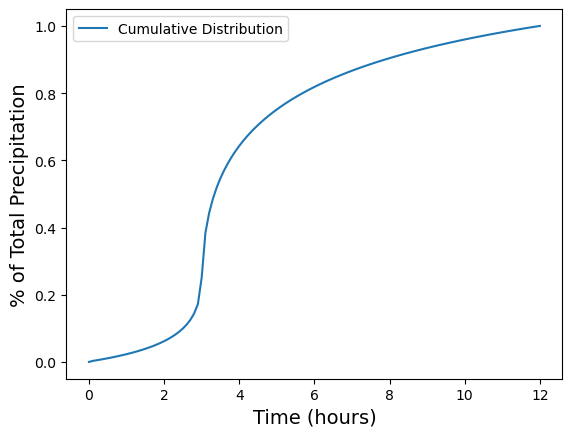

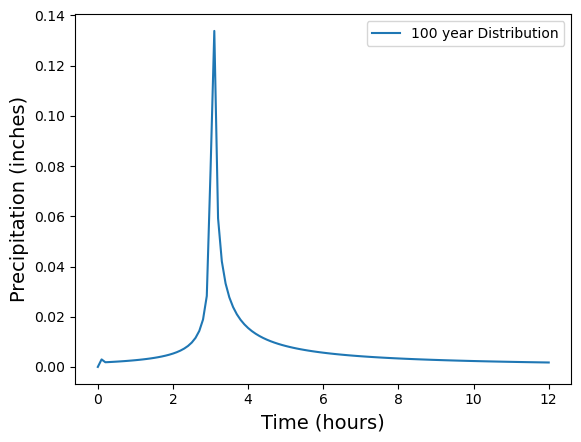

In [21]:
p1 = h100.plot('Time','Cumulative Distribution')
p1.legend()
p1.set_xlabel('Time (hours)', fontsize=14)
p1.set_ylabel('% of Total Precipitation', fontsize=14)

p2 = h100.plot('Time', '100 year Distribution')
p2.legend()
p2.set_xlabel('Time (hours)', fontsize=14)
p2.set_ylabel('Precipitation (inches)', fontsize=14)

p1
p2

### Save Nested Hyetograph:

In [22]:
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_nrcs_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN))

for i, d in enumerate(c_df.index.astype(str).tolist()[1:10]):
    table = hyetos[d][['ratio', 'slope']]
    hyetos[d].to_excel(writer, sheet_name = f'nrcs_hye_{d}')
    print(table)
writer.close()

         ratio     slope
time                    
0.0   0.000000  0.000000
0.1   0.000006  0.000006
0.2   0.001804  0.001798
0.3   0.003677  0.001873
0.4   0.005630  0.001953
...        ...       ...
11.6  0.993039  0.001798
11.7  0.994814  0.001774
11.8  0.996565  0.001751
11.9  0.998294  0.001729
12.0  1.000000  0.001706

[121 rows x 2 columns]
         ratio     slope
time                    
0.0   0.000000  0.000000
0.1   0.001307  0.001307
0.2   0.003123  0.001816
0.3   0.005014  0.001891
0.4   0.006986  0.001972
...        ...       ...
11.6  0.992971  0.001816
11.7  0.994762  0.001792
11.8  0.996531  0.001769
11.9  0.998277  0.001746
12.0  1.000000  0.001723

[121 rows x 2 columns]
         ratio     slope
time                    
0.0   0.000000  0.000000
0.1   0.001983  0.001983
0.2   0.003811  0.001828
0.3   0.005715  0.001903
0.4   0.007699  0.001985
...        ...       ...
11.6  0.992925  0.001828
11.7  0.994728  0.001804
11.8  0.996508  0.001780
11.9  0.998265  0.001757
12

---